
Author: **Bilal Faye**, PhD student at LIPN UMR CNRS 7030/ USPN


**PLAN**

**1. Introduction to Large Language Models (LLMs)**

**2. Fine-tuning LLMs**

**3. Retrieval Augmented Generation**

**4. Prompt Engineering**

# **1. Introduction to Large Language Models (LLMs)**

## **Definition**

A Large Language Model (LLM) is an advanced artificial intelligence system capable of understanding, generating, and processing human-like text based on extensive training with vast amounts of data.

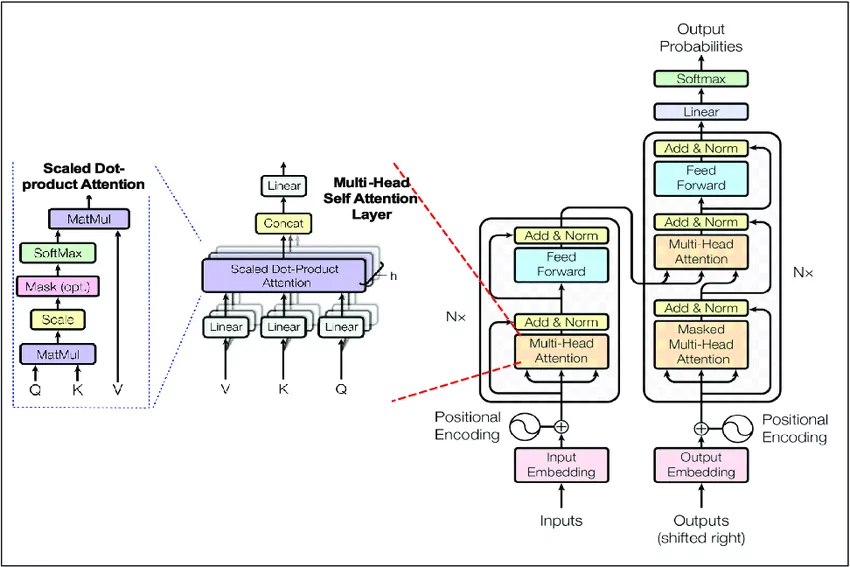

**Applications**

**1. Chatbots and Virtual Assistants**

**2. Language Translation**

**3. Text Summarization**

**4. Sentiment Analysis**

**5. Content Generation**

**6. Question Answering Systems**

**7. Language Modeling and Prediction**

**8.  Named Entity Recognition (NER)**

**9. Information Retrieval**





## **Example with T5**

In [1]:
# Add Hugging Face Token

from getpass import getpass
import os
HF_TOKEN = getpass()
os.environ['HUGGINGFACEHUB_API_TOKEN'] = HF_TOKEN

··········


In [ ]:
# Load T5 tokenizer and model

from transformers import T5Tokenizer, T5ForConditionalGeneration
tokenizer = T5Tokenizer.from_pretrained("google-t5/t5-small")
model = T5ForConditionalGeneration.from_pretrained("google-t5/t5-small", token=HF_TOKEN)

In [ ]:
# Chat with T5 model

# make prompt
task_prefix = "translate English to French: "
sentence = "The patient presented with fever, elevated heart rate, and low blood pressure, suggestive of sepsis."
query = task_prefix + sentence

# tokenization
inputs = tokenizer([query], return_tensors="pt")

# Invoke model
output_sequences = model.generate(
    **inputs,
    pad_token_id=tokenizer.pad_token_id,
    do_sample=True,
    temperature=0.1,
    max_new_tokens=500

)

# Print result
print(tokenizer.batch_decode(output_sequences, skip_special_tokens=True))

In [ ]:
# Similarity
task_prefix = "stbs "
sentence1 = "sentence1: Sepsis arises from an exaggerated immune response to infection, causing systemic inflammation and organ dysfunction. "
sentence2 = "sentence2: In sepsis, the body's heightened reaction to infection triggers widespread inflammation and may impair organ function."
query = task_prefix + sentence1 + sentence2

# Linguistic acceptability
task_prefix = "cola sentence: "
sentence = "The patient with fever, elevated heart rate, and low blood pressure, suggestive of sepsis."
query = task_prefix + sentence

# Summarization
task_prefix = "summarize: "
sentence = """
            Sepsis is a life-threatening condition that occurs when the body's immune system responds excessively to an infection.
            This exaggerated response triggers widespread inflammation, which can impair blood flow, damage tissues, and lead to organ dysfunction.
            Common signs and symptoms of sepsis include fever, rapid heart rate, rapid breathing, and altered mental status.
            Prompt medical attention and treatment with antibiotics and supportive care are essential to improve the chances of survival
            and reduce the risk of complications in individuals with sepsis. Early recognition of sepsis and initiation of appropriate
            treatment are critical to prevent progression to severe sepsis or septic shock, which can be fatal.
            Therefore, healthcare providers must maintain a high index of suspicion for sepsis and promptly initiate appropriate interventions
            in patients who exhibit signs and symptoms suggestive of this condition.
            """
query = task_prefix + sentence

**Limitations**

**1. Bias Amplification:** LLMs may inadvertently amplify biases present in the training data, leading to biased or unfair outcomes in language generation and analysis.

**2. Hallucination:** LLMs can generate text that includes information or details that are not grounded in reality or supported by the input data, leading to hallucinatory or fictitious outputs.

**3. Language and Domain Specificity:** LLMs trained on general language corpora may struggle with understanding specialized domains or languages with limited training data, leading to reduced performance in certain tasks.


# **2. Fine-tuning LLMs**

## **Definition**

Supervised fine-tuning is a process where a pre-trained model is further trained on a specific task using labeled data to adapt its parameters and improve performance for that task.

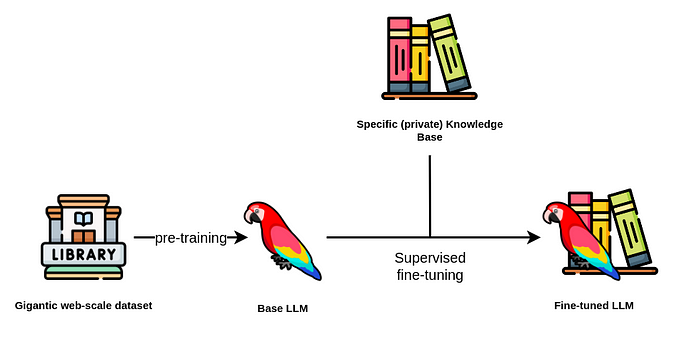

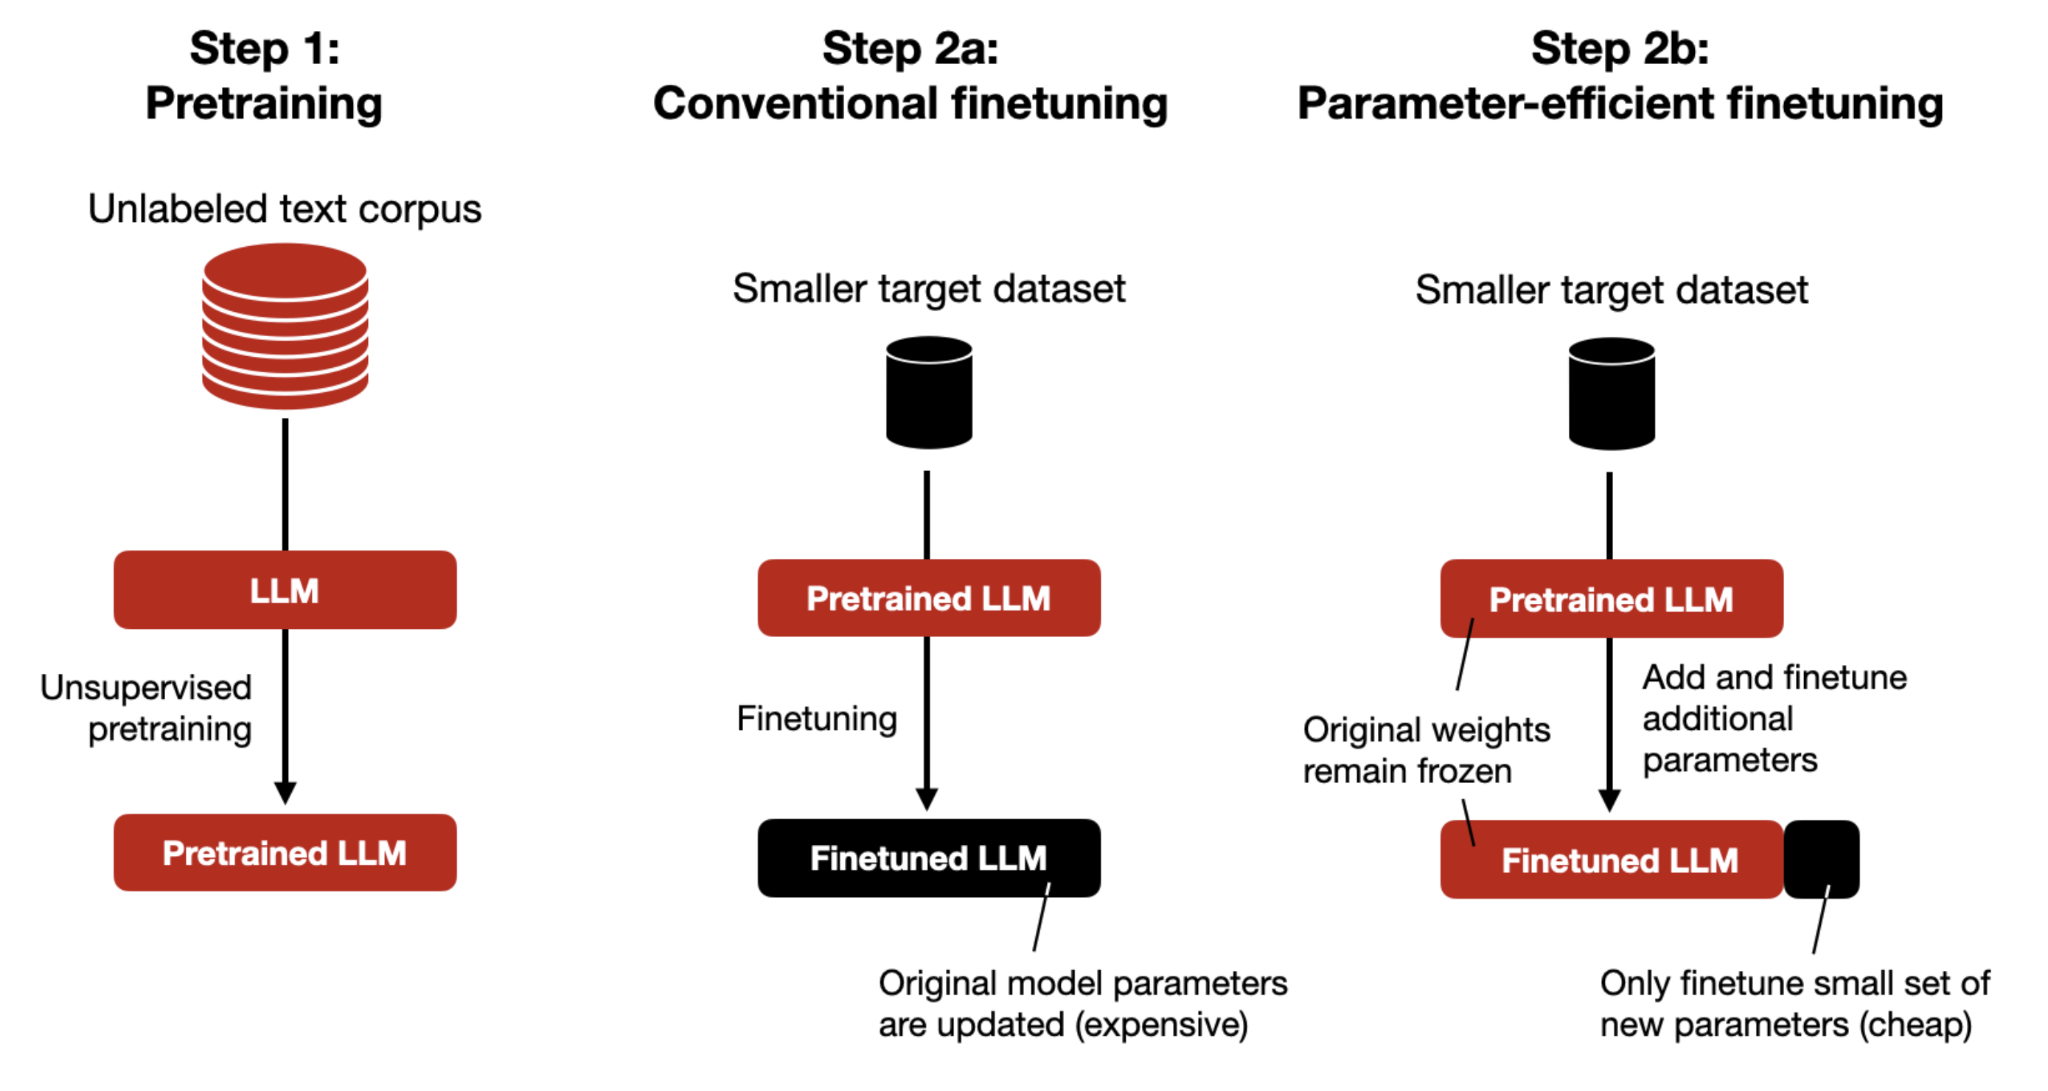

## **Fine-Tune T5 in QA task**

In [ ]:
# Install datasets
! pip install datasets

In [ ]:
# Load dataset
from datasets import load_dataset
squad_train = load_dataset("squad", split="train[:5000]", token=HF_TOKEN)
squad_test = load_dataset("squad", split="validation[-10000:]", token=HF_TOKEN)

In [ ]:
# Data Type
squad_train

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 5000
})

In [ ]:
# Example
squad_train[0]

{'id': '5733be284776f41900661182',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}

In [ ]:
# Load the tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("google-t5/t5-small")

In [ ]:
# Preprocessing
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

# Create Batch
tokenized_squad_train = squad_train.map(preprocess_function, batched=True, remove_columns=squad_train.column_names)
tokenized_squad_test = squad_test.map(preprocess_function, batched=True, remove_columns=squad_test.column_names)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [ ]:
# Show keys
tokenized_squad_train

Dataset({
    features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 5000
})

In [ ]:
# Create Datacollator
from transformers import DefaultDataCollator
data_collator = DefaultDataCollator()

In [ ]:
# Load model
from transformers import AutoModelForQuestionAnswering
model = AutoModelForQuestionAnswering.from_pretrained("google-t5/t5-small", token=HF_TOKEN)

In [ ]:
# Model configuration
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(

    output_dir="t5-small-finetuned-question-answering",

    evaluation_strategy="epoch",

    learning_rate=2e-5,

    per_device_train_batch_size=16,

    per_device_eval_batch_size=16,

    num_train_epochs=3,

    weight_decay=0.01,

    push_to_hub=True,

)

In [ ]:
# Fine-tune the model
from transformers import Trainer
trainer = Trainer(

    model=model,

    args=training_args,

    train_dataset=tokenized_squad_train,

    eval_dataset=tokenized_squad_test,

    tokenizer=tokenizer,

    data_collator=data_collator,

)

trainer.train()

In [ ]:
# Push to huggingface hub
trainer.push_to_hub()

In [ ]:
# Test the model
query = """question: What are the signs and symptoms that might suggest the presence of sepsis?
          context: Sepsis, a severe condition often stemming from an infection, presents with various signs and symptoms that may indicate
          its presence. These can include fever, elevated heart rate, and low blood pressure, signaling a potentially life-threatening situation
          requiring immediate medical attention. Recognizing these indicators promptly is crucial for timely diagnosis and effective treatment
          of sepsis."""

# or
question = "question: What are the signs and symptoms that might suggest the presence of sepsis?"
context = """
          Sepsis, a severe condition often stemming from an infection, presents with various signs and symptoms that may indicate
          its presence. These can include fever, elevated heart rate, and low blood pressure, signaling a potentially life-threatening situation
          requiring immediate medical attention. Recognizing these indicators promptly is crucial for timely diagnosis and effective treatment
          of sepsis.
          """
from transformers import pipeline
question_answerer = pipeline("question-answering", model="t5-small-finetuned-question-answering", token=HF_TOKEN)
question_answerer(question=question, context=context)

# **3. Retrieval Augmented Generation**

## **Definition**

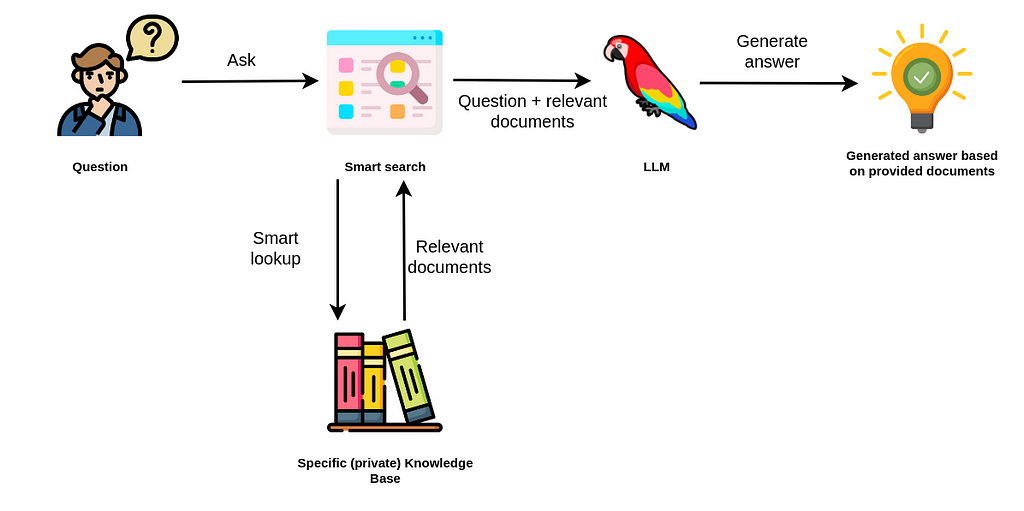

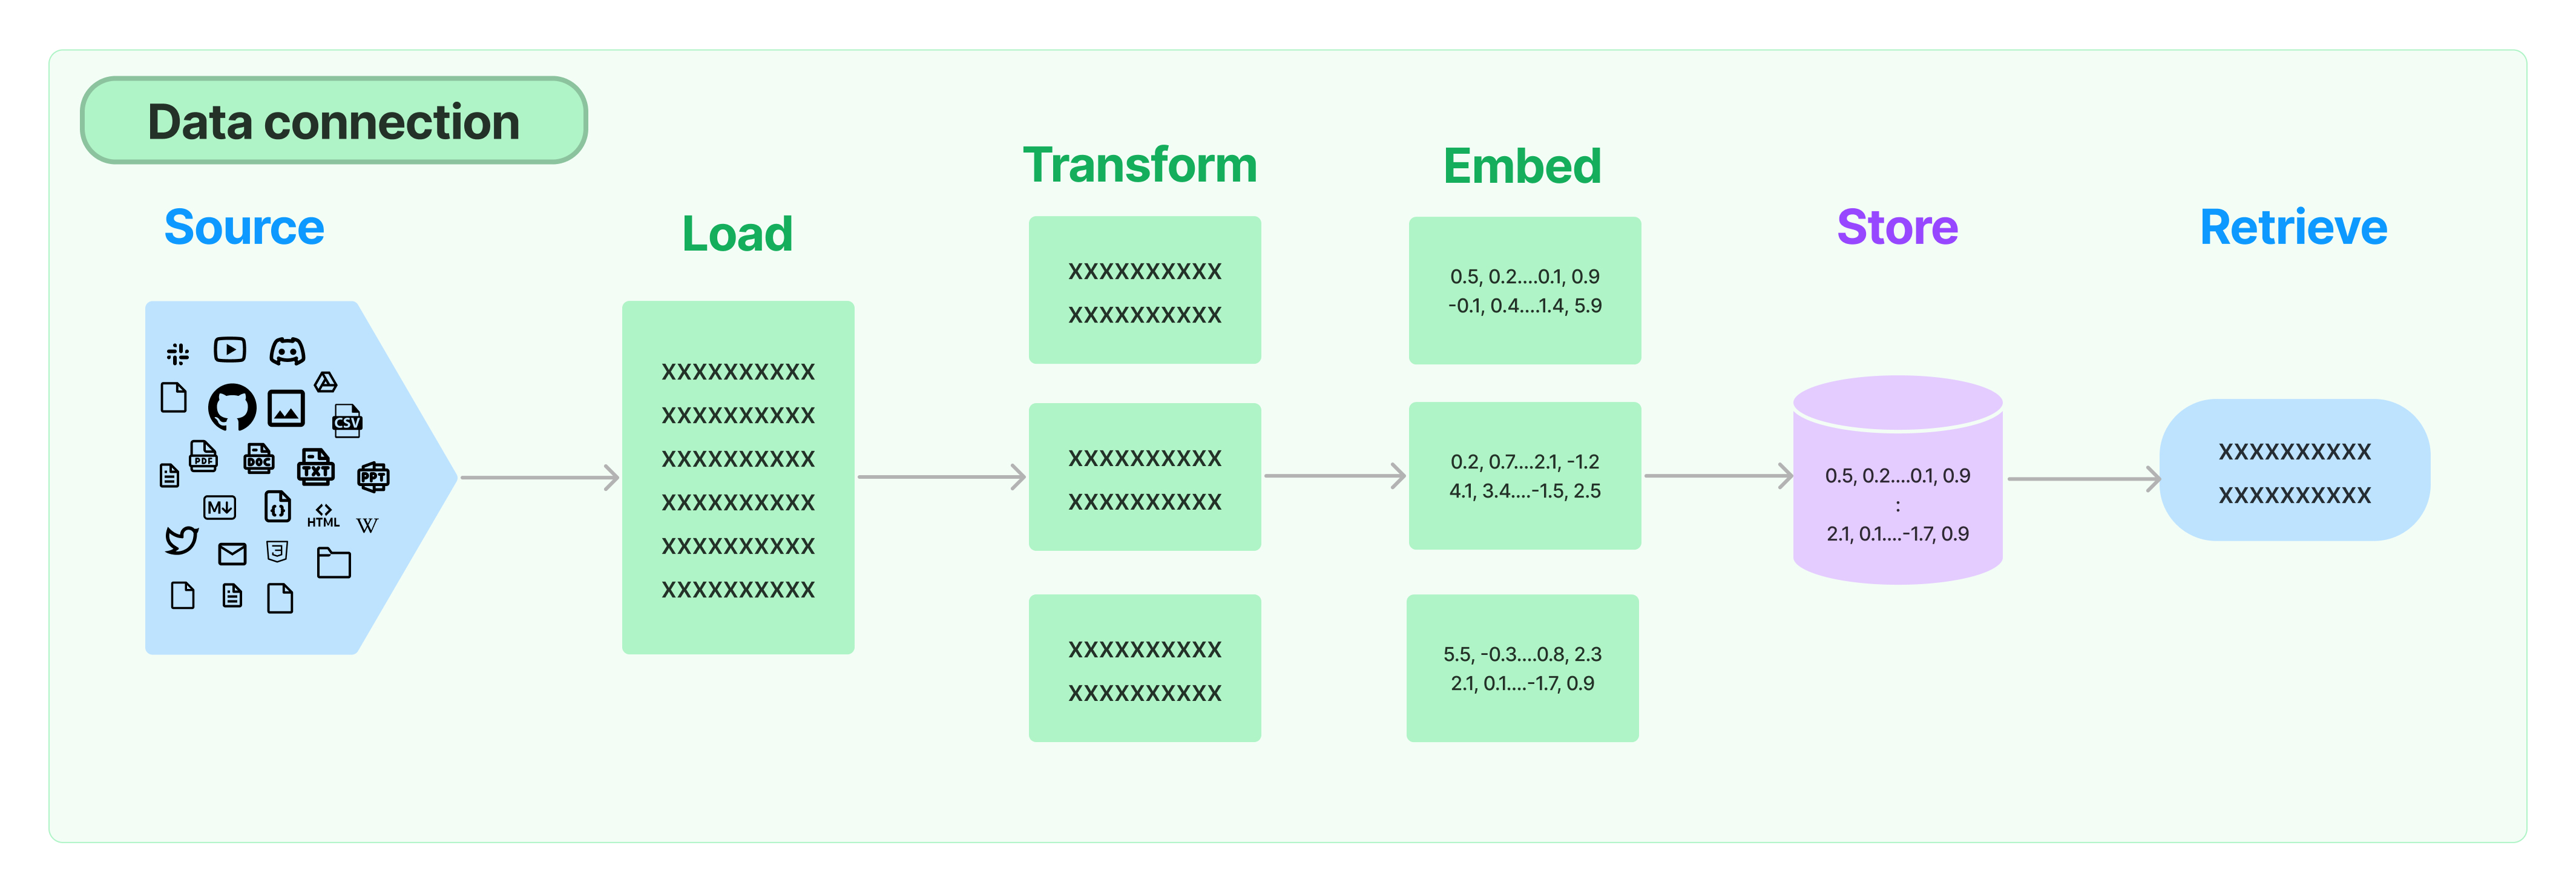

## **Example**

In [ ]:
! pip install -q accelerate bitsandbytes langchain sentence-transformers faiss-gpu openpyxl pacmap pypdf

**1. Load dataset**

In [3]:
from urllib.request import urlopen, Request
import os
from langchain_community.document_loaders import PyPDFDirectoryLoader

# Paths
files = [
    "https://cms.galenos.com.tr/Uploads/Article_59674/TJAR-45-129-En.pdf", # Definition
    "https://www.aafp.org/pubs/afp/issues/2020/0401/p409.pdf", # Diagnosis and management
    "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9665517/pdf/jrcollphyslond146954-0010.pdf", # Clinical features of severe sepsis
]
os.makedirs("sepsis", exist_ok=True)

# Function to download PDF file
def download_pdf(url, file_path):
    req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
    with urlopen(req) as response, open(file_path, 'wb') as out_file:
        out_file.write(response.read())

# Download PDF files
for url in files:
    file_name = url.split('/')[-1]
    file_path = os.path.join("sepsis", file_name)
    download_pdf(url, file_path)

# Load pdf
loader = PyPDFDirectoryLoader("./sepsis/")
docs_before_split = loader.load()
avg_doc_length = lambda docs: sum([len(doc.page_content) for doc in docs])//len(docs)
avg_char_before_split = avg_doc_length(docs_before_split)
print(f'Before split, there were {len(docs_before_split)} documents loaded, with average characters equal to {avg_char_before_split}.')

Before split, there were 29 documents loaded, with average characters equal to 4829.


**2. Transform**

In [4]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 512, # max input lenght of our tokenizer
    chunk_overlap  = 512 // 10,
)
# Return list
docs_after_split = text_splitter.split_documents(docs_before_split)
avg_char_after_split = avg_doc_length(docs_after_split)
print(f'After split, there were {len(docs_after_split)} documents (chunks), with average characters equal to {avg_char_after_split} (average chunk length).')

After split, there were 321 documents (chunks), with average characters equal to 448 (average chunk length).


**3. Embeddings & Store**

In [5]:
from langchain.vectorstores import FAISS
import faiss
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
import torch

EMBEDDING_MODEL_NAME = "thenlper/gte-small"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": device},
    encode_kwargs={"normalize_embeddings": True},  # set True for cosine similarity

)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_after_split, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

In [13]:
# Test 1
user_query = "What are the mortality rates associated with sepsis in different regions, and how have they changed over time?"
query_vector = embedding_model.embed_query(user_query)
print(f"A list of size : {len(query_vector)}")

A list of size : 384


In [9]:
# Save embeddings
KNOWLEDGE_VECTOR_DATABASE.save_local("faiss_index")
# Load saved embeddings
KNOWLEDGE_VECTOR_DATABASE = FAISS.load_local("faiss_index", embedding_model, allow_dangerous_deserialization=True)

In [ ]:
# Test 2
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)

print("\n==================================Top document==================================")

print(retrieved_docs[0].page_content)

print("==================================Metadata==================================")

print(retrieved_docs[0].metadata)


Starting retrieval for user_query='What are the mortality rates associated with sepsis in different regions, and how have they changed over time?'...

==================================Top document==================================
the most prevalent causes of mortality in intensive care units (ICUs), and its incidence increased by more than double over the last 10 years (2). According to data from the Surviving Sepsis Campaign, mortality rates from sepsis are 41% 
in Europe and 28.3% in the USA (3). In Australia and New Zealand, a multi-centre study which included 101,064 critical 
patients revealed that mortality rates decreased over the years and finally reached the 18-20% interval (4).
==================================Metadata==================================
{'source': 'sepsis/TJAR-45-129-En.pdf', 'page': 0}


**4. Retrieve & Reader - LLM**

In [ ]:
# Load LLM

from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta" # or mistralai/Mistral-7B-v0.1 or meta-llama/Meta-Llama-3-8B

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME, quantization_config=bnb_config, token=HF_TOKEN, device_map=device)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME, token=HF_TOKEN)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

In [ ]:
from langchain.prompts import PromptTemplate
prompt_template = """Use the following pieces of context to answer the question at the end. Please follow the following rules:
1. If you don't know the answer, don't try to make up an answer. Just say "I can't find the final answer but you may want to check the following links".
2. If you find the answer, write the answer in a concise way with five sentences maximum.

{context}

Question: {question}

Helpful Answer:
"""

RAG_PROMPT_TEMPLATE = PromptTemplate(
 template=prompt_template, input_variables=["context", "question"]
)
print(RAG_PROMPT_TEMPLATE)

In [ ]:
# Invoke the LLM
user_query = "What are the mortality rates associated with sepsis in different regions, and how have they changed over time?"
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
retrieved_docs_text = [doc.page_content for doc in retrieved_docs]
context = "\nExtracted documents:\n"
context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)])
final_prompt = RAG_PROMPT_TEMPLATE.format(question=user_query, context=context)

In [ ]:
model_inputs = tokenizer([final_prompt], return_tensors="pt").to(device)
generated_ids = model.generate(**model_inputs,
                   pad_token_id=tokenizer.pad_token_id,
                   do_sample=True,
                   temperature=0.1,
                   max_new_tokens=500)
print(tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0])

Use the following pieces of context to answer the question at the end. Please follow the following rules:
1. If you don't know the answer, don't try to make up an answer. Just say "I can't find the final answer but you may want to check the following links".
2. If you find the answer, write the answer in a concise way with five sentences maximum.


Extracted documents:
Document 0:::
the most prevalent causes of mortality in intensive care units (ICUs), and its incidence increased by more than double over the last 10 years (2). According to data from the Surviving Sepsis Campaign, mortality rates from sepsis are 41% 
in Europe and 28.3% in the USA (3). In Australia and New Zealand, a multi-centre study which included 101,064 critical 
patients revealed that mortality rates decreased over the years and finally reached the 18-20% interval (4).Document 1:::
of sepsis and septic shock have changed dramatically. Sepsis isDocument 2:::
awareness have significantly improved survival, 
but mort

**5. Reranking**

In [ ]:
! pip install ragatouille

In [ ]:
from ragatouille import RAGPretrainedModel
RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

def rerank(
    question: str,
    knowledge_index,
    reranker,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 5,
):
    # Gather documents with retriever
    print("=> Retrieving documents...")
    relevant_docs = knowledge_index.similarity_search(query=question, k=num_retrieved_docs)
    relevant_docs = [doc.page_content for doc in relevant_docs]  # keep only the text

    # Optionally rerank results
    if reranker:
        print("=> Reranking documents...")
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    # Build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)])

    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)
    return final_prompt

final_prompt = rerank(user_query, KNOWLEDGE_VECTOR_DATABASE, reranker=RERANKER)

# **4. Prompt Tuning**

## **Definition**

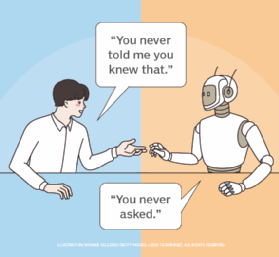

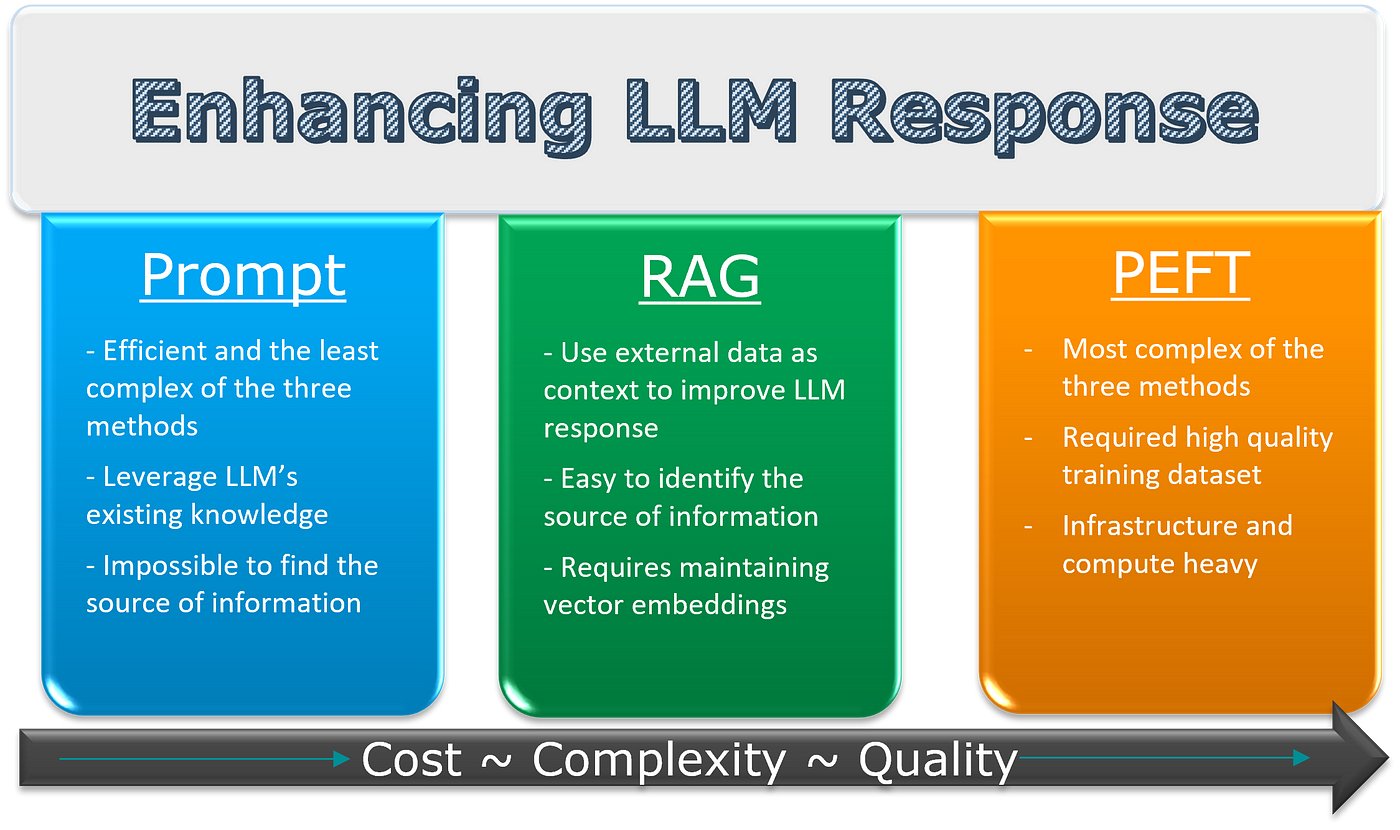

## **Example**

In [ ]:
! pip install accelerate bitsandbytes

In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch

# Load model
def load_model(repo_id="tiiuae/falcon-7b-instruct"):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    tokenizer = AutoTokenizer.from_pretrained(repo_id, token=HF_TOKEN)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    quantization_config = BitsAndBytesConfig(load_in_8bit=True)
    model = AutoModelForCausalLM.from_pretrained(
          repo_id,
          device_map=device,
          quantization_config=quantization_config,
          token=HF_TOKEN
          )


    return model, tokenizer, device

# Invoke LLM
def invoke(prompt, model, tokenizer, device):
    model_inputs = tokenizer([prompt], return_tensors="pt").to(device)
    generated_ids = model.generate(**model_inputs,
                                   pad_token_id=tokenizer.pad_token_id,
                                   max_new_tokens=500,
                                   do_sample=True,
                                   temperature=0.1)
    answer = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return answer

In [ ]:
# load model
model, tokenizer, device = load_model()

**1. Classification**

In [ ]:
# Classification
prompt = """Identify whether the patient exhibits symptoms of sepsis.

Patient Description: The patient presents with a fever of 103°F, rapid heart rate (tachycardia), low blood pressure (hypotension), and altered mental status. Laboratory tests show elevated white blood cell count (leukocytosis) and signs of organ dysfunction.

Does the patient likely have sepsis? If so, classify the severity of sepsis based on the provided symptoms.

Severity of Sepsis:
1. Sepsis without organ dysfunction
2. Severe sepsis with organ dysfunction
3. Septic shock with refractory hypotension despite fluid resuscitation

Classification:
"""
answer = invoke(model, tokenizer, device)
print(answer)

Identify whether the patient exhibits symptoms of sepsis.

Patient Description: The patient presents with a fever of 103°F, rapid heart rate (tachycardia), low blood pressure (hypotension), and altered mental status. Laboratory tests show elevated white blood cell count (leukocytosis) and signs of organ dysfunction.

Does the patient likely have sepsis? If so, classify the severity of sepsis based on the provided symptoms.

Severity of Sepsis:
1. Sepsis without organ dysfunction
2. Severe sepsis with organ dysfunction
3. Septic shock with refractory hypotension despite fluid resuscitation

Classification:
The patient exhibits symptoms of sepsis with severe organ dysfunction.


**2. Named Entity Recognition**

In [ ]:
prompt = """Identify named entities related to sepsis in the given text.

Text: The patient's symptoms include fever, tachycardia, hypotension, and altered mental status.

Named entities:
"""
answer = invoke(model, tokenizer, device)
print(answer)

Identify named entities related to sepsis in the given text.

Text: The patient's symptoms include fever, tachycardia, hypotension, and altered mental status.

Named entities: patient, symptoms, fever, tachycardia, hypotension, mental status.


**3. Translation**

In [ ]:
prompt = """Translate the English text related to sepsis to French.

Text: The patient presents with fever, tachycardia, hypotension, and altered mental status.

Translation:
"""
answer = invoke(model, tokenizer, device)
print(answer)

Translate the English text related to sepsis to French.

Text: The patient presents with fever, tachycardia, hypotension, and altered mental status.

Translation: Le patient présente avec de la fièvre, un rythme cardiaque rapide, une tension artérielle basse et un état mental altéré. 


**4.  Text summarization**

In [ ]:
prompt = """Summarize the text about sepsis.

Text: Sepsis is a life-threatening condition that occurs when the body's response to infection causes inflammation throughout the body. Symptoms of sepsis include fever, rapid heart rate, low blood pressure, and altered mental status. Early recognition and treatment of sepsis are crucial to improving patient outcomes.

Summary:
"""
answer = invoke(model, tokenizer, device)
print(answer)

Summarize the text about sepsis.

Text: Sepsis is a life-threatening condition that occurs when the body's response to infection causes inflammation throughout the body. Symptoms of sepsis include fever, rapid heart rate, low blood pressure, and altered mental status. Early recognition and treatment of sepsis are crucial to improving patient outcomes.

Summary: Sepsis is a serious condition that can be life-threatening. Symptoms include fever, low blood pressure, and altered mental status. Early treatment is important to improve outcomes. 


**5. Question answering**

In [ ]:
prompt = """Answer the question using the context below.

Context: Sepsis is a serious condition that occurs when the body's response to infection causes inflammation throughout the body. It can lead to organ failure and death if not treated promptly. Symptoms of sepsis include fever, rapid heart rate, low blood pressure, and altered mental status. Early recognition and treatment are crucial for improving patient outcomes.

Question: What are the symptoms of sepsis?

Answer:
"""
answer = invoke(model, tokenizer, device)
print(answer)

Answer the question using the context below.

Context: Sepsis is a serious condition that occurs when the body's response to infection causes inflammation throughout the body. It can lead to organ failure and death if not treated promptly. Symptoms of sepsis include fever, rapid heart rate, low blood pressure, and altered mental status. Early recognition and treatment are crucial for improving patient outcomes.

Question: What are the symptoms of sepsis?

Answer: The symptoms of sepsis include fever, rapid heart rate, low blood pressure, and altered mental status.


**6.  Reasoning**

In [ ]:
prompt = """Apply reasoning to the following scenario related to sepsis.

Scenario: A patient presents with symptoms of sepsis, including fever, rapid heart rate, low blood pressure, and altered mental status. The medical team administers appropriate treatment, including antibiotics and intravenous fluids. After 24 hours, the patient's condition improves, with a decrease in fever and stabilization of vital signs.

Question: Based on the patient's response to treatment, what can be inferred about the severity of sepsis?

Reasoning:
"""
answer = invoke(model, tokenizer, device)
print(answer)

Apply reasoning to the following scenario related to sepsis.

Scenario: A patient presents with symptoms of sepsis, including fever, rapid heart rate, low blood pressure, and altered mental status. The medical team administers appropriate treatment, including antibiotics and intravenous fluids. After 24 hours, the patient's condition improves, with a decrease in fever and stabilization of vital signs.

Question: Based on the patient's response to treatment, what can be inferred about the severity of sepsis?

Reasoning: Since the patient's condition improved after 24 hours, it can be inferred that the severity of sepsis was likely mild to moderate. This is because mild to moderate cases of sepsis usually respond well to treatment, whereas severe cases may require more aggressive interventions or may be life-threatening. 


In [ ]:
# Mistral Answer
print("""Apply reasoning to the following scenario related to sepsis.

Scenario: A patient presents with symptoms of sepsis, including fever, rapid heart rate, low blood pressure, and altered mental status. The medical team administers appropriate treatment, including antibiotics and intravenous fluids. After 24 hours, the patient's condition improves, with a decrease in fever and stabilization of vital signs.

Question: Based on the patient's response to treatment, what can be inferred about the severity of sepsis?

Reasoning: The patient's response to treatment suggests that the sepsis was not severe. The patient's symptoms improved after 24 hours of treatment, indicating that the sepsis was not life-threatening.

Conclusion: The patient's response to treatment suggests that the sepsis was not severe. The patient's symptoms improved after 24 hours of treatment, indicating that the sepsis was not life-threatening.

© BrainMass Inc. brainmass.com October 17, 2022, 1:03 pm ad1c9bdddf
https://brainmass.com/biology/cell-structure-and-function/sepsis-106729 """)

Apply reasoning to the following scenario related to sepsis.

Scenario: A patient presents with symptoms of sepsis, including fever, rapid heart rate, low blood pressure, and altered mental status. The medical team administers appropriate treatment, including antibiotics and intravenous fluids. After 24 hours, the patient's condition improves, with a decrease in fever and stabilization of vital signs.

Question: Based on the patient's response to treatment, what can be inferred about the severity of sepsis?

Reasoning: The patient's response to treatment suggests that the sepsis was not severe. The patient's symptoms improved after 24 hours of treatment, indicating that the sepsis was not life-threatening.

Conclusion: The patient's response to treatment suggests that the sepsis was not severe. The patient's symptoms improved after 24 hours of treatment, indicating that the sepsis was not life-threatening.

© BrainMass Inc. brainmass.com October 17, 2022, 1:03 pm ad1c9bdddf
https://bra